In [1]:
from calibrimbore import sauron

import numpy as np
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

from astropy.coordinates import SkyCoord
import astropy.units as u
from copy import deepcopy

## load in the filter and make the composite relation with sauron

The filter file must be a text file with with 2 columns, where the first is wavelength in angstrom and the second is the throughput.

Making a composite filter of input band and ps1


<IPython.core.display.Math object>

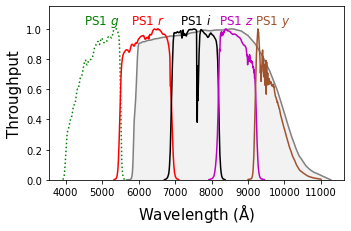

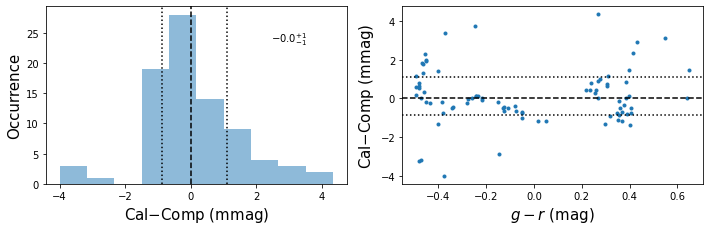

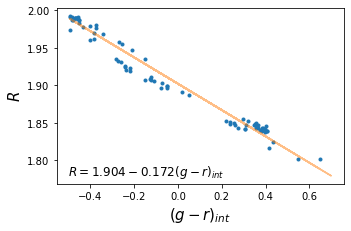

In [3]:
tess_filter = 'tess.dat'
comp = sauron(band=tess_filter,gr_lims=[-.5,0.8],plot=True,cubic_corr=False)

If you want something in the southern hemisphere that isn't covered by PS1, then a relation to SkyMapper can be used

Making a composite filter of input band and skymapper


<IPython.core.display.Math object>

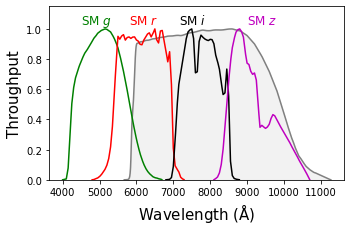

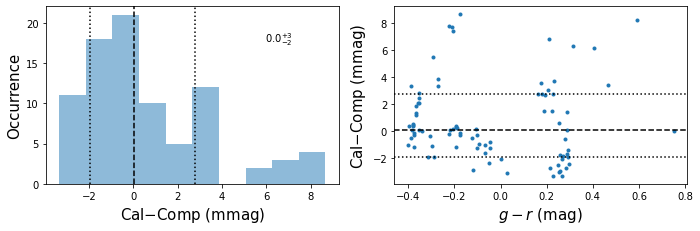

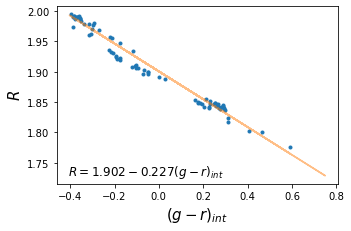

In [4]:
comp_sm = sauron(band=tess_filter,gr_lims=[-.5,0.8],plot=True,cubic_corr=False,system='skymapper')

Both systems do a pretty good job, although the narrower bands of PS1 make reconstructions a little better. The colour limits are only used to select which stars are used in the creation of the zeropoint. Generally it is best to have $g-r < 0.8$ since there are few Calspec sources past that colour range.

To save the state of sauron to use it in other instances so the relations don't need to be recalculated use:

In [5]:
comp.save_state('tess_ps1')

The save can then be easily read in with

In [8]:
comp = sauron(load_state='tess_ps1.npy')
comp.print_comp()

<IPython.core.display.Math object>

With the relations calculated magnitudes can be calculated in the input bandpass using the PS1/SkyMapper source catalogs. If you already have photometry and positions for sources in your images, you can input them with ra and dec into the estimate_mag() function, however, in this test case we will just query a region to get example sources.

In [22]:
from calibrimbore import get_ps1_region

In [23]:
coords = ['08:05:11.1 -11:32:01.9']
c = SkyCoord(coords,unit=(u.hourangle, u.deg))
# get all PS1 sources in a radius 1 deg circle
sources = get_ps1_region(c.ra.deg,c.dec.deg,size=1*60**2)

ind = (np.isfinite(sources.r.values) & np.isfinite(sources.i.values) 
       & np.isfinite(sources.z.values) & (sources['g'].values < 19) & (sources['g'].values > 13))

sources = sources.iloc[ind]

Querying regions with Vizier


With estimate_mag() we use stellar locus regression to calculate the exxtinction contribution for sources within a 0.2 deg field of view. This choice is made to ensure that there are always enough sources for reliable fits, while being small enough to not have significant variability in extinction across the field of view.

In [25]:
tess_estimates = comp.estimate_mag(mags = sources)
print(tess_estimates[:100])

Querying regions with Vizier
30733
33950
[        nan 16.52099382 17.81520549         nan         nan 17.3429821
 16.04833947 15.83523493 14.40354378 18.00282265 16.56809614 17.7503921
 16.9284375  17.60211324 17.95843606 16.97508731 18.01309613 12.60607754
 17.74212469 14.64882423         nan 13.82266364 15.80677732 17.78042645
 17.07541953 16.00593517 17.46713577 17.33599318 17.77621459 16.71037913
 14.33155888 15.37690304 16.08388595 14.98737271 16.19960267 15.03274101
 18.01108516 17.61685389 17.22847903 17.32062355 16.27309976 17.88542725
 15.74290903 15.80494545         nan 15.12118742 13.38823016 17.5995949
 17.7134904  14.51995712 14.65610136 18.05543051 18.11056046 16.27791126
 17.86028898         nan 17.67760711 18.04020558 17.47183561 17.05972486
 16.84702653 16.41985163 14.70363777         nan 15.86848965 16.72882346
 17.39813445 17.34521302         nan 17.34394119 15.98353645 17.90982955
 17.80379442 15.39592869 17.76645025 17.39174504 17.6742531  18.4401788
 17.77115926 1

By matching the sources with real photometric measurements, the zeropoint can be calculated by simply taking the difference between the measured photometry in the input filter, and the predicted photometry:
$zp = m_{pred} - m_{sys}$.

Since we are not comparing to real data, here is a quick comparison between the predicted TESS magnitude and the observed PS1 r-band. Clearly the broader TESS band views sources differently to r-band.

Text(0, 0.5, 'tess - r')

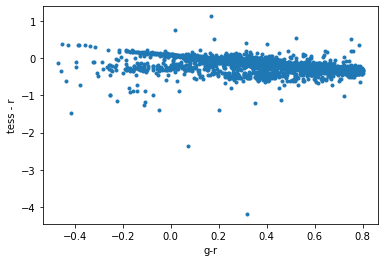

In [26]:
plt.figure()
plt.plot(sources['g']-sources['r'],tess_estimates-sources['r'],'.')
plt.xlabel('g-r')
plt.ylabel('tess - r')